# **THE SEMANTIC SEGMENTATION OF HUMANS**
> ***with the help of coco-person(lite)-dataset**

* Model is under developing but already shows good results!
* There would be much more accuracy if not for memory limits!
(feels like there are not enough training patterns, 36.1k examples in training data)
* Only train data used
* Results are shown below(on 14 photo)

![UNET_arch](https://neerc.ifmo.ru/wiki/images/d/dc/U-net-architecture.png)


In [1]:
pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/426.2 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 13.2 MB/s eta 0:00:00


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import random
from typing import Any, Callable, List, Optional, Tuple

from pycocotools.coco import COCO
import skimage.io as io
from torchvision import io, transforms
import torchvision.transforms.functional as TF

import math

In [3]:
class CNA(nn.Module): 
  def __init__(self, in_nc, out_nc, stride=1):
    super().__init__()
    self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
    self.norm = nn.BatchNorm2d(out_nc)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    out = self.act(out)
    return out


In [4]:
class UnetBlock(nn.Module): 
  def __init__(self, in_nc, inner_nc, out_nc, inner_block=None): 
   super().__init__()
   self.mp = nn.MaxPool2d(kernel_size=2)
   self.conv1 = CNA(in_nc, inner_nc)
   self.conv2 = CNA(inner_nc, inner_nc)
   self.inner_block = inner_block 
   self.conv_cat1 = CNA(inner_nc + in_nc, out_nc)
   self.conv_cat2 = CNA(out_nc, out_nc)

  def forward(self, x):
    _, _, h, w = x.shape

    inner = self.mp(x) 
    inner = self.conv1(inner) 
    inner = self.conv2(inner)
    if self.inner_block is not None:
      inner = self.inner_block(inner)

    inner = F.upsample(inner, size=(h, w), mode='bilinear')
    inner = torch.cat([inner, x], axis=1) 
    inner = self.conv_cat1(inner)
    out = self.conv_cat2(inner)

    return out


In [5]:
class Unet(nn.Module):
  def __init__(self, in_nc=1, nc=64, out_nc=1): 
      super().__init__()

      self.cna1 = CNA(in_nc, nc) 
      self.cna2 = CNA(nc, nc) 

      unet_block1 = UnetBlock(8*nc, 16*nc, 8*nc)
      unet_block2 = UnetBlock(4*nc, 8*nc, 4*nc, unet_block1)
      unet_block3 = UnetBlock(2*nc, 4*nc, 2*nc, unet_block2)
      self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block3)

      self.conv_last = nn.Conv2d(nc, 1, 3, padding=1)

  def forward(self, x):
    out = self.cna1(x)
    out = self.cna2(out)
    out = self.unet_block(out)
    out = self.conv_last(out)

    return out


In [6]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.images_filenames = sorted(os.listdir(self.images_directory)) 
        
    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx] 
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1] 
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"] 
            mask = transformed["mask"]
        return image, mask

In [8]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ToTensorV2(),
    ]
)

# val_transform = A.Compose(
#     [
#         A.PadIfNeeded(min_height=256, min_width=256),
#         A.CenterCrop(256, 256),
#         #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

In [9]:
ROOT_PATH = Path("/kaggle/input/cocod2017person/coco2017person")
BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)

In [10]:
train_annotations = COCO(ROOT_PATH / "annotations/instances_train2017.json")
# valid_annotations = COCO(ROOT_PATH / "annotations/instances_val2017.json")

loading annotations into memory...


Done (t=27.48s)
creating index...


index created!


In [11]:
cat_ids = train_annotations.getCatIds(supNms=["person"])

train_img_ids = []
for cat in cat_ids: 
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
train_img_ids = list(set(train_img_ids)) 

images_folder = "/kaggle/input/cocod2017person/coco2017person/train2017"
all_images = os.listdir(images_folder)
all_images_set = set(all_images)
selected_train_img_ids = [img_id for img_id in train_img_ids if f"{str(img_id).zfill(12)}.jpg" in all_images_set]
print(f"Number of selected training images: {len(selected_train_img_ids)}")



# valid_img_ids = []
# for cat in cat_ids:
#     valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
# valid_img_ids = list(set(valid_img_ids))

# images_folder = "/kaggle/input/cocod2017person/coco2017person/val2017"
# all_images = os.listdir(images_folder)
# all_images_set = set(all_images)
# selected_val_img_ids = [img_id for img_id in valid_img_ids if f"{str(img_id).zfill(12)}.jpg" in all_images_set]
# print(f"Number of selected training images: {len(selected_val_img_ids)}")

Number of selected training images: 32057


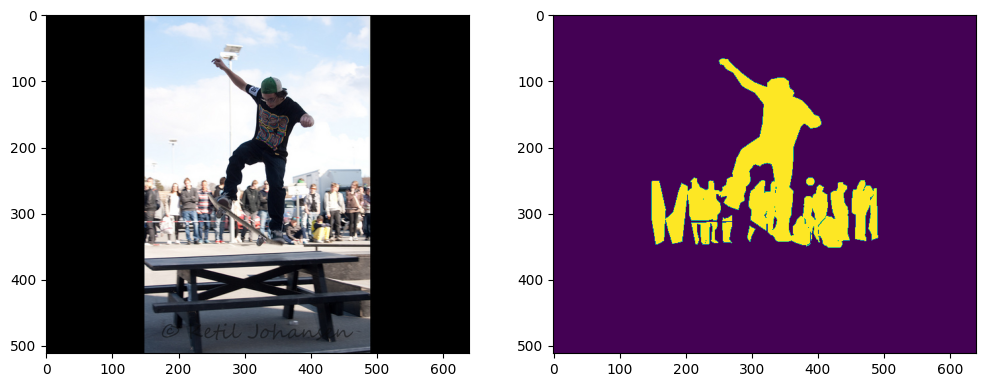

In [12]:
i = 0 
img_data = train_annotations.loadImgs(selected_train_img_ids[i])
ann_ids = train_annotations.getAnnIds(imgIds=img_data[0]['id'], catIds=cat_ids, iscrowd=None) # Здесь получаются идентификаторы аннотаций
anns = train_annotations.loadAnns(ann_ids) 
mask = np.max(np.stack([train_annotations.annToMask(ann) * ann["category_id"] for ann in anns]), axis=0)

img = io.read_image(str(ROOT_PATH / "train2017" / img_data[0]["file_name"]))/255.0 # img = io.read_image(str(ROOT_PATH / "train2017" / img_data[0]["file_name"]))/255.0:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask)
plt.show()

imgg = img

In [13]:
class ImageData(torch.utils.data.Dataset):
    def __init__(
        self,
        annotations: COCO,
        img_ids: List[int],
        cat_ids: List[int],
        root_path: Path,
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'],
            catIds=self.cat_ids,
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"]
                                                 for ann in anns]), axis=0)).unsqueeze(0)

        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)

        if self.transform is not None:
            return self.transform(img, mask)

        return img, mask

# IMAGE AUGMENTATIONS

In [14]:
def train_transform(
    img1: torch.LongTensor,
    img2: torch.LongTensor
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))

    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)

    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)

    return img1, img2

In [15]:
train_data = ImageData(train_annotations, selected_train_img_ids, cat_ids, ROOT_PATH / "train2017", train_transform)
# valid_data = ImageData(valid_annotations, selected_val_img_ids, cat_ids, ROOT_PATH / "val2017", train_transform)

train_dl = torch.utils.data.DataLoader(
    train_data,
    BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)

# valid_dl = torch.utils.data.DataLoader(
#     valid_data,
#     BATCH_SIZE,
#     shuffle=False,
#     drop_last=False,
#     num_workers=4,
#     pin_memory=True,
# )

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


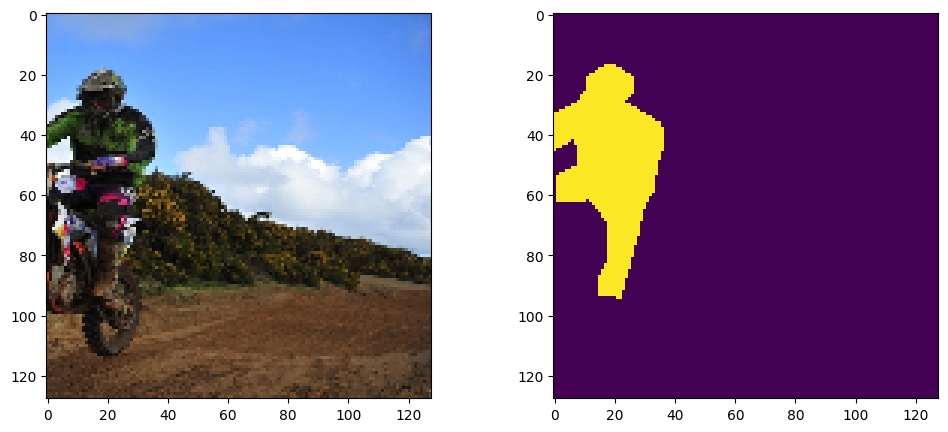

In [16]:
img, mask = train_data[2]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

In [17]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64, 1, 128, 128])


# TRAINING

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model = Unet(in_nc=3, nc=64, out_nc=1)
unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [19]:
count_parameters(unet_model)

31385345

In [20]:
epochs = 10
for epoch in range(epochs):
    loss_val = 0
    for sample in (pbar := tqdm(train_dl)):
        img, mask = sample
        img = img.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32) 
        optimizer.zero_grad()

        pred = unet_model(img)
        loss = loss_fn(pred, mask)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

    scheduler.step()
    print(f'{loss_val/len(train_dl)}\t lr: {scheduler.get_last_lr()}')


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


  0%|          | 1/500 [00:03<32:42,  3.93s/it]

  0%|          | 2/500 [00:04<17:21,  2.09s/it]

  1%|          | 3/500 [00:05<12:27,  1.50s/it]

  1%|          | 4/500 [00:06<10:07,  1.22s/it]

  1%|          | 5/500 [00:07<08:49,  1.07s/it]

  1%|          | 6/500 [00:07<08:03,  1.02it/s]

  1%|▏         | 7/500 [00:08<07:33,  1.09it/s]

  2%|▏         | 8/500 [00:09<07:13,  1.13it/s]

  2%|▏         | 9/500 [00:10<07:00,  1.17it/s]

  2%|▏         | 10/500 [00:11<06:50,  1.19it/s]

  2%|▏         | 11/500 [00:11<06:43,  1.21it/s]

  2%|▏         | 12/500 [00:12<06:39,  1.22it/s]

  3%|▎         | 13/500 [00:13<06:35,  1.23it/s]

  3%|▎         | 14/500 [00:14<06:33,  1.24it/s]

  3%|▎         | 15/500 [00:15<06:30,  1.24it/s]

  3%|▎         | 16/500 [00:15<06:29,  1.24it/s]

  3%|▎         | 17/500 [00:16<06:28,  1.24it/s]

  4%|▎         | 18/500 [00:17<06:27,  1.24it/s]

  4%|▍         | 19/500 [00:18<06:26,  1.25it/s]

  4%|▍         | 20/500 [00:19<06:25,  1.25it/s]

  4%|▍         | 21/500 [00:19<06:25,  1.24it/s]

  4%|▍         | 22/500 [00:20<06:23,  1.25it/s]

  5%|▍         | 23/500 [00:21<06:21,  1.25it/s]

  5%|▍         | 24/500 [00:22<06:21,  1.25it/s]

  5%|▌         | 25/500 [00:23<06:21,  1.24it/s]

  5%|▌         | 26/500 [00:23<06:20,  1.25it/s]

  5%|▌         | 27/500 [00:24<06:20,  1.24it/s]

  6%|▌         | 28/500 [00:25<06:19,  1.24it/s]

  6%|▌         | 29/500 [00:26<06:19,  1.24it/s]

  6%|▌         | 30/500 [00:27<06:19,  1.24it/s]

  6%|▌         | 31/500 [00:27<06:18,  1.24it/s]

  6%|▋         | 32/500 [00:28<06:17,  1.24it/s]

  7%|▋         | 33/500 [00:29<06:16,  1.24it/s]

  7%|▋         | 34/500 [00:30<06:16,  1.24it/s]

  7%|▋         | 35/500 [00:31<06:15,  1.24it/s]

  7%|▋         | 36/500 [00:32<06:15,  1.24it/s]

  7%|▋         | 37/500 [00:32<06:15,  1.23it/s]

  8%|▊         | 38/500 [00:33<06:14,  1.23it/s]

  8%|▊         | 39/500 [00:34<06:13,  1.23it/s]

  8%|▊         | 40/500 [00:35<06:11,  1.24it/s]

  8%|▊         | 41/500 [00:36<06:10,  1.24it/s]

  8%|▊         | 42/500 [00:36<06:10,  1.24it/s]

  9%|▊         | 43/500 [00:37<06:09,  1.24it/s]

  9%|▉         | 44/500 [00:38<06:09,  1.23it/s]

  9%|▉         | 45/500 [00:39<06:08,  1.23it/s]

  9%|▉         | 46/500 [00:40<06:08,  1.23it/s]

  9%|▉         | 47/500 [00:40<06:07,  1.23it/s]

 10%|▉         | 48/500 [00:41<06:06,  1.23it/s]

 10%|▉         | 49/500 [00:42<06:05,  1.23it/s]

 10%|█         | 50/500 [00:43<06:05,  1.23it/s]

 10%|█         | 51/500 [00:44<06:04,  1.23it/s]

 10%|█         | 52/500 [00:44<06:03,  1.23it/s]

 11%|█         | 53/500 [00:45<06:02,  1.23it/s]

 11%|█         | 54/500 [00:46<06:01,  1.23it/s]

 11%|█         | 55/500 [00:47<06:01,  1.23it/s]

 11%|█         | 56/500 [00:48<06:00,  1.23it/s]

 11%|█▏        | 57/500 [00:49<05:59,  1.23it/s]

 12%|█▏        | 58/500 [00:49<05:59,  1.23it/s]

 12%|█▏        | 59/500 [00:50<05:58,  1.23it/s]

 12%|█▏        | 60/500 [00:51<05:57,  1.23it/s]

 12%|█▏        | 61/500 [00:52<05:56,  1.23it/s]

 12%|█▏        | 62/500 [00:53<05:56,  1.23it/s]

 13%|█▎        | 63/500 [00:53<05:55,  1.23it/s]

 13%|█▎        | 64/500 [00:54<05:54,  1.23it/s]

 13%|█▎        | 65/500 [00:55<05:55,  1.23it/s]

 13%|█▎        | 66/500 [00:56<05:54,  1.23it/s]

 13%|█▎        | 67/500 [00:57<05:53,  1.23it/s]

 14%|█▎        | 68/500 [00:58<05:52,  1.23it/s]

 14%|█▍        | 69/500 [00:58<05:52,  1.22it/s]

 14%|█▍        | 70/500 [00:59<05:51,  1.22it/s]

 14%|█▍        | 71/500 [01:00<05:51,  1.22it/s]

 14%|█▍        | 72/500 [01:01<05:50,  1.22it/s]

 15%|█▍        | 73/500 [01:02<05:49,  1.22it/s]

 15%|█▍        | 74/500 [01:02<05:49,  1.22it/s]

 15%|█▌        | 75/500 [01:03<05:48,  1.22it/s]

 15%|█▌        | 76/500 [01:04<05:47,  1.22it/s]

 15%|█▌        | 77/500 [01:05<05:47,  1.22it/s]

 16%|█▌        | 78/500 [01:06<05:46,  1.22it/s]

 16%|█▌        | 79/500 [01:07<05:46,  1.21it/s]

 16%|█▌        | 80/500 [01:07<05:45,  1.22it/s]

 16%|█▌        | 81/500 [01:08<05:44,  1.22it/s]

 16%|█▋        | 82/500 [01:09<05:44,  1.21it/s]

 17%|█▋        | 83/500 [01:10<05:43,  1.21it/s]

 17%|█▋        | 84/500 [01:11<05:42,  1.21it/s]

 17%|█▋        | 85/500 [01:11<05:42,  1.21it/s]

 17%|█▋        | 86/500 [01:12<05:41,  1.21it/s]

 17%|█▋        | 87/500 [01:13<05:40,  1.21it/s]

 18%|█▊        | 88/500 [01:14<05:40,  1.21it/s]

 18%|█▊        | 89/500 [01:15<05:39,  1.21it/s]

 18%|█▊        | 90/500 [01:16<05:39,  1.21it/s]

 18%|█▊        | 91/500 [01:16<05:39,  1.21it/s]

 18%|█▊        | 92/500 [01:17<05:38,  1.21it/s]

 19%|█▊        | 93/500 [01:18<05:37,  1.20it/s]

 19%|█▉        | 94/500 [01:19<05:37,  1.20it/s]

 19%|█▉        | 95/500 [01:20<05:36,  1.20it/s]

 19%|█▉        | 96/500 [01:21<05:35,  1.20it/s]

 19%|█▉        | 97/500 [01:21<05:35,  1.20it/s]

 20%|█▉        | 98/500 [01:22<05:34,  1.20it/s]

 20%|█▉        | 99/500 [01:23<05:33,  1.20it/s]

 20%|██        | 100/500 [01:24<05:32,  1.20it/s]

 20%|██        | 101/500 [01:25<05:31,  1.20it/s]

 20%|██        | 102/500 [01:26<05:31,  1.20it/s]

 21%|██        | 103/500 [01:26<05:30,  1.20it/s]

 21%|██        | 104/500 [01:27<05:29,  1.20it/s]

 21%|██        | 105/500 [01:28<05:28,  1.20it/s]

 21%|██        | 106/500 [01:29<05:27,  1.20it/s]

 21%|██▏       | 107/500 [01:30<05:26,  1.20it/s]

 22%|██▏       | 108/500 [01:31<05:25,  1.20it/s]

 22%|██▏       | 109/500 [01:31<05:24,  1.20it/s]

 22%|██▏       | 110/500 [01:32<05:24,  1.20it/s]

 22%|██▏       | 111/500 [01:33<05:23,  1.20it/s]

 22%|██▏       | 112/500 [01:34<05:23,  1.20it/s]

 23%|██▎       | 113/500 [01:35<05:23,  1.20it/s]

 23%|██▎       | 114/500 [01:36<05:22,  1.20it/s]

 23%|██▎       | 115/500 [01:36<05:21,  1.20it/s]

 23%|██▎       | 116/500 [01:37<05:21,  1.19it/s]

 23%|██▎       | 117/500 [01:38<05:20,  1.19it/s]

 24%|██▎       | 118/500 [01:39<05:19,  1.19it/s]

 24%|██▍       | 119/500 [01:40<05:19,  1.19it/s]

 24%|██▍       | 120/500 [01:41<05:19,  1.19it/s]

 24%|██▍       | 121/500 [01:41<05:18,  1.19it/s]

 24%|██▍       | 122/500 [01:42<05:17,  1.19it/s]

 25%|██▍       | 123/500 [01:43<05:16,  1.19it/s]

 25%|██▍       | 124/500 [01:44<05:17,  1.19it/s]

 25%|██▌       | 125/500 [01:45<05:16,  1.19it/s]

 25%|██▌       | 126/500 [01:46<05:15,  1.19it/s]

 25%|██▌       | 127/500 [01:47<05:14,  1.19it/s]

 26%|██▌       | 128/500 [01:47<05:13,  1.19it/s]

 26%|██▌       | 129/500 [01:48<05:12,  1.19it/s]

 26%|██▌       | 130/500 [01:49<05:12,  1.18it/s]

 26%|██▌       | 131/500 [01:50<05:11,  1.18it/s]

 26%|██▋       | 132/500 [01:51<05:11,  1.18it/s]

 27%|██▋       | 133/500 [01:52<05:10,  1.18it/s]

 27%|██▋       | 134/500 [01:52<05:09,  1.18it/s]

 27%|██▋       | 135/500 [01:53<05:08,  1.18it/s]

 27%|██▋       | 136/500 [01:54<05:08,  1.18it/s]

 27%|██▋       | 137/500 [01:55<05:07,  1.18it/s]

 28%|██▊       | 138/500 [01:56<05:07,  1.18it/s]

 28%|██▊       | 139/500 [01:57<05:06,  1.18it/s]

 28%|██▊       | 140/500 [01:58<05:05,  1.18it/s]

 28%|██▊       | 141/500 [01:58<05:04,  1.18it/s]

 28%|██▊       | 142/500 [01:59<05:03,  1.18it/s]

 29%|██▊       | 143/500 [02:00<05:03,  1.18it/s]

 29%|██▉       | 144/500 [02:01<05:02,  1.18it/s]

 29%|██▉       | 145/500 [02:02<05:01,  1.18it/s]

 29%|██▉       | 146/500 [02:03<05:00,  1.18it/s]

 29%|██▉       | 147/500 [02:03<04:59,  1.18it/s]

 30%|██▉       | 148/500 [02:04<04:58,  1.18it/s]

 30%|██▉       | 149/500 [02:05<04:57,  1.18it/s]

 30%|███       | 150/500 [02:06<04:56,  1.18it/s]

 30%|███       | 151/500 [02:07<04:55,  1.18it/s]

 30%|███       | 152/500 [02:08<04:54,  1.18it/s]

 31%|███       | 153/500 [02:09<04:53,  1.18it/s]

 31%|███       | 154/500 [02:09<04:52,  1.18it/s]

 31%|███       | 155/500 [02:10<04:51,  1.18it/s]

 31%|███       | 156/500 [02:11<04:50,  1.18it/s]

 31%|███▏      | 157/500 [02:12<04:49,  1.19it/s]

 32%|███▏      | 158/500 [02:13<04:48,  1.18it/s]

 32%|███▏      | 159/500 [02:14<04:47,  1.19it/s]

 32%|███▏      | 160/500 [02:14<04:46,  1.19it/s]

 32%|███▏      | 161/500 [02:15<04:45,  1.19it/s]

 32%|███▏      | 162/500 [02:16<04:44,  1.19it/s]

 33%|███▎      | 163/500 [02:17<04:43,  1.19it/s]

 33%|███▎      | 164/500 [02:18<04:43,  1.19it/s]

 33%|███▎      | 165/500 [02:19<04:41,  1.19it/s]

 33%|███▎      | 166/500 [02:20<04:41,  1.19it/s]

 33%|███▎      | 167/500 [02:20<04:39,  1.19it/s]

 34%|███▎      | 168/500 [02:21<04:39,  1.19it/s]

 34%|███▍      | 169/500 [02:22<04:38,  1.19it/s]

 34%|███▍      | 170/500 [02:23<04:37,  1.19it/s]

 34%|███▍      | 171/500 [02:24<04:36,  1.19it/s]

 34%|███▍      | 172/500 [02:25<04:35,  1.19it/s]

 35%|███▍      | 173/500 [02:25<04:34,  1.19it/s]

 35%|███▍      | 174/500 [02:26<04:33,  1.19it/s]

 35%|███▌      | 175/500 [02:27<04:32,  1.19it/s]

 35%|███▌      | 176/500 [02:28<04:32,  1.19it/s]

 35%|███▌      | 177/500 [02:29<04:30,  1.19it/s]

 36%|███▌      | 178/500 [02:30<04:30,  1.19it/s]

 36%|███▌      | 179/500 [02:30<04:29,  1.19it/s]

 36%|███▌      | 180/500 [02:31<04:28,  1.19it/s]

 36%|███▌      | 181/500 [02:32<04:27,  1.19it/s]

 36%|███▋      | 182/500 [02:33<04:26,  1.19it/s]

 37%|███▋      | 183/500 [02:34<04:25,  1.19it/s]

 37%|███▋      | 184/500 [02:35<04:24,  1.19it/s]

 37%|███▋      | 185/500 [02:35<04:23,  1.19it/s]

 37%|███▋      | 186/500 [02:36<04:22,  1.20it/s]

 37%|███▋      | 187/500 [02:37<04:22,  1.19it/s]

 38%|███▊      | 188/500 [02:38<04:21,  1.19it/s]

 38%|███▊      | 189/500 [02:39<04:20,  1.20it/s]

 38%|███▊      | 190/500 [02:40<04:19,  1.19it/s]

 38%|███▊      | 191/500 [02:40<04:19,  1.19it/s]

 38%|███▊      | 192/500 [02:41<04:17,  1.19it/s]

 39%|███▊      | 193/500 [02:42<04:16,  1.20it/s]

 39%|███▉      | 194/500 [02:43<04:16,  1.19it/s]

 39%|███▉      | 195/500 [02:44<04:15,  1.19it/s]

 39%|███▉      | 196/500 [02:45<04:14,  1.19it/s]

 39%|███▉      | 197/500 [02:46<04:13,  1.19it/s]

 40%|███▉      | 198/500 [02:46<04:12,  1.19it/s]

 40%|███▉      | 199/500 [02:47<04:11,  1.20it/s]

 40%|████      | 200/500 [02:48<04:11,  1.19it/s]

 40%|████      | 201/500 [02:49<04:10,  1.19it/s]

 40%|████      | 202/500 [02:50<04:09,  1.19it/s]

 41%|████      | 203/500 [02:51<04:08,  1.19it/s]

 41%|████      | 204/500 [02:51<04:08,  1.19it/s]

 41%|████      | 205/500 [02:52<04:07,  1.19it/s]

 41%|████      | 206/500 [02:53<04:06,  1.19it/s]

 41%|████▏     | 207/500 [02:54<04:05,  1.19it/s]

 42%|████▏     | 208/500 [02:55<04:04,  1.19it/s]

 42%|████▏     | 209/500 [02:56<04:04,  1.19it/s]

 42%|████▏     | 210/500 [02:56<04:03,  1.19it/s]

 42%|████▏     | 211/500 [02:57<04:02,  1.19it/s]

 42%|████▏     | 212/500 [02:58<04:01,  1.19it/s]

 43%|████▎     | 213/500 [02:59<04:00,  1.19it/s]

 43%|████▎     | 214/500 [03:00<04:00,  1.19it/s]

 43%|████▎     | 215/500 [03:01<03:59,  1.19it/s]

 43%|████▎     | 216/500 [03:01<03:58,  1.19it/s]

 43%|████▎     | 217/500 [03:02<03:57,  1.19it/s]

 44%|████▎     | 218/500 [03:03<03:56,  1.19it/s]

 44%|████▍     | 219/500 [03:04<03:56,  1.19it/s]

 44%|████▍     | 220/500 [03:05<03:55,  1.19it/s]

 44%|████▍     | 221/500 [03:06<03:54,  1.19it/s]

 44%|████▍     | 222/500 [03:06<03:53,  1.19it/s]

 45%|████▍     | 223/500 [03:07<03:52,  1.19it/s]

 45%|████▍     | 224/500 [03:08<03:52,  1.19it/s]

 45%|████▌     | 225/500 [03:09<03:51,  1.19it/s]

 45%|████▌     | 226/500 [03:10<03:50,  1.19it/s]

 45%|████▌     | 227/500 [03:11<03:49,  1.19it/s]

 46%|████▌     | 228/500 [03:12<03:48,  1.19it/s]

 46%|████▌     | 229/500 [03:12<03:48,  1.19it/s]

 46%|████▌     | 230/500 [03:13<03:47,  1.19it/s]

 46%|████▌     | 231/500 [03:14<03:46,  1.19it/s]

 46%|████▋     | 232/500 [03:15<03:45,  1.19it/s]

 47%|████▋     | 233/500 [03:16<03:44,  1.19it/s]

 47%|████▋     | 234/500 [03:17<03:44,  1.19it/s]

 47%|████▋     | 235/500 [03:17<03:43,  1.19it/s]

 47%|████▋     | 236/500 [03:18<03:42,  1.19it/s]

 47%|████▋     | 237/500 [03:19<03:41,  1.19it/s]

 48%|████▊     | 238/500 [03:20<03:40,  1.19it/s]

 48%|████▊     | 239/500 [03:21<03:39,  1.19it/s]

 48%|████▊     | 240/500 [03:22<03:38,  1.19it/s]

 48%|████▊     | 241/500 [03:22<03:38,  1.19it/s]

 48%|████▊     | 242/500 [03:23<03:37,  1.19it/s]

 49%|████▊     | 243/500 [03:24<03:36,  1.19it/s]

 49%|████▉     | 244/500 [03:25<03:35,  1.19it/s]

 49%|████▉     | 245/500 [03:26<03:34,  1.19it/s]

 49%|████▉     | 246/500 [03:27<03:33,  1.19it/s]

 49%|████▉     | 247/500 [03:28<03:33,  1.19it/s]

 50%|████▉     | 248/500 [03:28<03:32,  1.19it/s]

 50%|████▉     | 249/500 [03:29<03:31,  1.19it/s]

 50%|█████     | 250/500 [03:30<03:30,  1.19it/s]

 50%|█████     | 251/500 [03:31<03:30,  1.19it/s]

 50%|█████     | 252/500 [03:32<03:28,  1.19it/s]

 51%|█████     | 253/500 [03:33<03:28,  1.19it/s]

 51%|█████     | 254/500 [03:33<03:27,  1.19it/s]

 51%|█████     | 255/500 [03:34<03:26,  1.19it/s]

 51%|█████     | 256/500 [03:35<03:26,  1.18it/s]

 51%|█████▏    | 257/500 [03:36<03:25,  1.18it/s]

 52%|█████▏    | 258/500 [03:37<03:24,  1.18it/s]

 52%|█████▏    | 259/500 [03:38<03:23,  1.18it/s]

 52%|█████▏    | 260/500 [03:39<03:22,  1.19it/s]

 52%|█████▏    | 261/500 [03:39<03:21,  1.18it/s]

 52%|█████▏    | 262/500 [03:40<03:20,  1.19it/s]

 53%|█████▎    | 263/500 [03:41<03:19,  1.19it/s]

 53%|█████▎    | 264/500 [03:42<03:19,  1.18it/s]

 53%|█████▎    | 265/500 [03:43<03:18,  1.19it/s]

 53%|█████▎    | 266/500 [03:44<03:17,  1.19it/s]

 53%|█████▎    | 267/500 [03:44<03:16,  1.19it/s]

 54%|█████▎    | 268/500 [03:45<03:15,  1.19it/s]

 54%|█████▍    | 269/500 [03:46<03:14,  1.19it/s]

 54%|█████▍    | 270/500 [03:47<03:13,  1.19it/s]

 54%|█████▍    | 271/500 [03:48<03:13,  1.18it/s]

 54%|█████▍    | 272/500 [03:49<03:12,  1.19it/s]

 55%|█████▍    | 273/500 [03:49<03:11,  1.19it/s]

 55%|█████▍    | 274/500 [03:50<03:10,  1.19it/s]

 55%|█████▌    | 275/500 [03:51<03:09,  1.19it/s]

 55%|█████▌    | 276/500 [03:52<03:08,  1.19it/s]

 55%|█████▌    | 277/500 [03:53<03:07,  1.19it/s]

 56%|█████▌    | 278/500 [03:54<03:07,  1.19it/s]

 56%|█████▌    | 279/500 [03:55<03:06,  1.19it/s]

 56%|█████▌    | 280/500 [03:55<03:05,  1.19it/s]

 56%|█████▌    | 281/500 [03:56<03:04,  1.19it/s]

 56%|█████▋    | 282/500 [03:57<03:03,  1.19it/s]

 57%|█████▋    | 283/500 [03:58<03:02,  1.19it/s]

 57%|█████▋    | 284/500 [03:59<03:01,  1.19it/s]

 57%|█████▋    | 285/500 [04:00<03:01,  1.19it/s]

 57%|█████▋    | 286/500 [04:00<03:00,  1.19it/s]

 57%|█████▋    | 287/500 [04:01<02:59,  1.19it/s]

 58%|█████▊    | 288/500 [04:02<02:58,  1.19it/s]

 58%|█████▊    | 289/500 [04:03<02:57,  1.19it/s]

 58%|█████▊    | 290/500 [04:04<02:56,  1.19it/s]

 58%|█████▊    | 291/500 [04:05<02:55,  1.19it/s]

 58%|█████▊    | 292/500 [04:05<02:55,  1.19it/s]

 59%|█████▊    | 293/500 [04:06<02:54,  1.19it/s]

 59%|█████▉    | 294/500 [04:07<02:53,  1.19it/s]

 59%|█████▉    | 295/500 [04:08<02:52,  1.19it/s]

 59%|█████▉    | 296/500 [04:09<02:52,  1.18it/s]

 59%|█████▉    | 297/500 [04:10<02:51,  1.19it/s]

 60%|█████▉    | 298/500 [04:11<02:50,  1.18it/s]

 60%|█████▉    | 299/500 [04:11<02:49,  1.19it/s]

 60%|██████    | 300/500 [04:12<02:48,  1.19it/s]

 60%|██████    | 301/500 [04:13<02:47,  1.19it/s]

 60%|██████    | 302/500 [04:14<02:46,  1.19it/s]

 61%|██████    | 303/500 [04:15<02:45,  1.19it/s]

 61%|██████    | 304/500 [04:16<02:44,  1.19it/s]

 61%|██████    | 305/500 [04:16<02:44,  1.19it/s]

 61%|██████    | 306/500 [04:17<02:43,  1.19it/s]

 61%|██████▏   | 307/500 [04:18<02:42,  1.19it/s]

 62%|██████▏   | 308/500 [04:19<02:41,  1.19it/s]

 62%|██████▏   | 309/500 [04:20<02:40,  1.19it/s]

 62%|██████▏   | 310/500 [04:21<02:39,  1.19it/s]

 62%|██████▏   | 311/500 [04:21<02:39,  1.19it/s]

 62%|██████▏   | 312/500 [04:22<02:38,  1.19it/s]

 63%|██████▎   | 313/500 [04:23<02:37,  1.19it/s]

 63%|██████▎   | 314/500 [04:24<02:36,  1.19it/s]

 63%|██████▎   | 315/500 [04:25<02:35,  1.19it/s]

 63%|██████▎   | 316/500 [04:26<02:34,  1.19it/s]

 63%|██████▎   | 317/500 [04:27<02:33,  1.19it/s]

 64%|██████▎   | 318/500 [04:27<02:33,  1.19it/s]

 64%|██████▍   | 319/500 [04:28<02:32,  1.19it/s]

 64%|██████▍   | 320/500 [04:29<02:31,  1.19it/s]

 64%|██████▍   | 321/500 [04:30<02:30,  1.19it/s]

 64%|██████▍   | 322/500 [04:31<02:29,  1.19it/s]

 65%|██████▍   | 323/500 [04:32<02:28,  1.19it/s]

 65%|██████▍   | 324/500 [04:32<02:28,  1.19it/s]

 65%|██████▌   | 325/500 [04:33<02:27,  1.19it/s]

 65%|██████▌   | 326/500 [04:34<02:26,  1.19it/s]

 65%|██████▌   | 327/500 [04:35<02:25,  1.19it/s]

 66%|██████▌   | 328/500 [04:36<02:24,  1.19it/s]

 66%|██████▌   | 329/500 [04:37<02:23,  1.19it/s]

 66%|██████▌   | 330/500 [04:37<02:22,  1.19it/s]

 66%|██████▌   | 331/500 [04:38<02:22,  1.19it/s]

 66%|██████▋   | 332/500 [04:39<02:21,  1.19it/s]

 67%|██████▋   | 333/500 [04:40<02:20,  1.19it/s]

 67%|██████▋   | 334/500 [04:41<02:19,  1.19it/s]

 67%|██████▋   | 335/500 [04:42<02:18,  1.19it/s]

 67%|██████▋   | 336/500 [04:43<02:18,  1.19it/s]

 67%|██████▋   | 337/500 [04:43<02:17,  1.19it/s]

 68%|██████▊   | 338/500 [04:44<02:16,  1.19it/s]

 68%|██████▊   | 339/500 [04:45<02:15,  1.19it/s]

 68%|██████▊   | 340/500 [04:46<02:14,  1.19it/s]

 68%|██████▊   | 341/500 [04:47<02:13,  1.19it/s]

 68%|██████▊   | 342/500 [04:48<02:13,  1.19it/s]

 69%|██████▊   | 343/500 [04:48<02:12,  1.19it/s]

 69%|██████▉   | 344/500 [04:49<02:11,  1.19it/s]

 69%|██████▉   | 345/500 [04:50<02:10,  1.19it/s]

 69%|██████▉   | 346/500 [04:51<02:09,  1.19it/s]

 69%|██████▉   | 347/500 [04:52<02:08,  1.19it/s]

 70%|██████▉   | 348/500 [04:53<02:08,  1.19it/s]

 70%|██████▉   | 349/500 [04:53<02:07,  1.19it/s]

 70%|███████   | 350/500 [04:54<02:06,  1.19it/s]

 70%|███████   | 351/500 [04:55<02:05,  1.19it/s]

 70%|███████   | 352/500 [04:56<02:04,  1.19it/s]

 71%|███████   | 353/500 [04:57<02:03,  1.19it/s]

 71%|███████   | 354/500 [04:58<02:02,  1.19it/s]

 71%|███████   | 355/500 [04:59<02:02,  1.19it/s]

 71%|███████   | 356/500 [04:59<02:01,  1.19it/s]

 71%|███████▏  | 357/500 [05:00<02:00,  1.19it/s]

 72%|███████▏  | 358/500 [05:01<01:59,  1.19it/s]

 72%|███████▏  | 359/500 [05:02<01:58,  1.19it/s]

 72%|███████▏  | 360/500 [05:03<01:57,  1.19it/s]

 72%|███████▏  | 361/500 [05:04<01:57,  1.19it/s]

 72%|███████▏  | 362/500 [05:04<01:56,  1.19it/s]

 73%|███████▎  | 363/500 [05:05<01:55,  1.19it/s]

 73%|███████▎  | 364/500 [05:06<01:54,  1.19it/s]

 73%|███████▎  | 365/500 [05:07<01:53,  1.19it/s]

 73%|███████▎  | 366/500 [05:08<01:52,  1.19it/s]

 73%|███████▎  | 367/500 [05:09<01:52,  1.19it/s]

 74%|███████▎  | 368/500 [05:09<01:51,  1.19it/s]

 74%|███████▍  | 369/500 [05:10<01:50,  1.19it/s]

 74%|███████▍  | 370/500 [05:11<01:49,  1.19it/s]

 74%|███████▍  | 371/500 [05:12<01:48,  1.19it/s]

 74%|███████▍  | 372/500 [05:13<01:47,  1.19it/s]

 75%|███████▍  | 373/500 [05:14<01:46,  1.19it/s]

 75%|███████▍  | 374/500 [05:15<01:46,  1.19it/s]

 75%|███████▌  | 375/500 [05:15<01:45,  1.19it/s]

 75%|███████▌  | 376/500 [05:16<01:44,  1.19it/s]

 75%|███████▌  | 377/500 [05:17<01:43,  1.19it/s]

 76%|███████▌  | 378/500 [05:18<01:42,  1.19it/s]

 76%|███████▌  | 379/500 [05:19<01:41,  1.19it/s]

 76%|███████▌  | 380/500 [05:20<01:41,  1.19it/s]

 76%|███████▌  | 381/500 [05:20<01:40,  1.19it/s]

 76%|███████▋  | 382/500 [05:21<01:39,  1.19it/s]

 77%|███████▋  | 383/500 [05:22<01:38,  1.19it/s]

 77%|███████▋  | 384/500 [05:23<01:37,  1.19it/s]

 77%|███████▋  | 385/500 [05:24<01:36,  1.19it/s]

 77%|███████▋  | 386/500 [05:25<01:36,  1.19it/s]

 77%|███████▋  | 387/500 [05:25<01:35,  1.19it/s]

 78%|███████▊  | 388/500 [05:26<01:34,  1.19it/s]

 78%|███████▊  | 389/500 [05:27<01:33,  1.19it/s]

 78%|███████▊  | 390/500 [05:28<01:32,  1.19it/s]

 78%|███████▊  | 391/500 [05:29<01:31,  1.19it/s]

 78%|███████▊  | 392/500 [05:30<01:30,  1.19it/s]

 79%|███████▊  | 393/500 [05:31<01:30,  1.19it/s]

 79%|███████▉  | 394/500 [05:31<01:29,  1.19it/s]

 79%|███████▉  | 395/500 [05:32<01:28,  1.19it/s]

 79%|███████▉  | 396/500 [05:33<01:27,  1.19it/s]

 79%|███████▉  | 397/500 [05:34<01:26,  1.19it/s]

 80%|███████▉  | 398/500 [05:35<01:25,  1.19it/s]

 80%|███████▉  | 399/500 [05:36<01:25,  1.19it/s]

 80%|████████  | 400/500 [05:36<01:24,  1.19it/s]

 80%|████████  | 401/500 [05:37<01:23,  1.19it/s]

 80%|████████  | 402/500 [05:38<01:22,  1.19it/s]

 81%|████████  | 403/500 [05:39<01:21,  1.19it/s]

 81%|████████  | 404/500 [05:40<01:20,  1.19it/s]

 81%|████████  | 405/500 [05:41<01:19,  1.19it/s]

 81%|████████  | 406/500 [05:41<01:19,  1.19it/s]

 81%|████████▏ | 407/500 [05:42<01:18,  1.19it/s]

 82%|████████▏ | 408/500 [05:43<01:17,  1.19it/s]

 82%|████████▏ | 409/500 [05:44<01:16,  1.19it/s]

 82%|████████▏ | 410/500 [05:45<01:15,  1.19it/s]

 82%|████████▏ | 411/500 [05:46<01:14,  1.19it/s]

 82%|████████▏ | 412/500 [05:47<01:14,  1.19it/s]

 83%|████████▎ | 413/500 [05:47<01:13,  1.19it/s]

 83%|████████▎ | 414/500 [05:48<01:12,  1.19it/s]

 83%|████████▎ | 415/500 [05:49<01:11,  1.19it/s]

 83%|████████▎ | 416/500 [05:50<01:10,  1.19it/s]

 83%|████████▎ | 417/500 [05:51<01:09,  1.19it/s]

 84%|████████▎ | 418/500 [05:52<01:09,  1.19it/s]

 84%|████████▍ | 419/500 [05:52<01:08,  1.19it/s]

 84%|████████▍ | 420/500 [05:53<01:07,  1.19it/s]

 84%|████████▍ | 421/500 [05:54<01:06,  1.19it/s]

 84%|████████▍ | 422/500 [05:55<01:05,  1.19it/s]

 85%|████████▍ | 423/500 [05:56<01:04,  1.19it/s]

 85%|████████▍ | 424/500 [05:57<01:03,  1.19it/s]

 85%|████████▌ | 425/500 [05:57<01:03,  1.19it/s]

 85%|████████▌ | 426/500 [05:58<01:02,  1.19it/s]

 85%|████████▌ | 427/500 [05:59<01:01,  1.19it/s]

 86%|████████▌ | 428/500 [06:00<01:00,  1.19it/s]

 86%|████████▌ | 429/500 [06:01<00:59,  1.19it/s]

 86%|████████▌ | 430/500 [06:02<00:58,  1.19it/s]

 86%|████████▌ | 431/500 [06:03<00:58,  1.19it/s]

 86%|████████▋ | 432/500 [06:03<00:57,  1.19it/s]

 87%|████████▋ | 433/500 [06:04<00:56,  1.19it/s]

 87%|████████▋ | 434/500 [06:05<00:55,  1.19it/s]

 87%|████████▋ | 435/500 [06:06<00:54,  1.19it/s]

 87%|████████▋ | 436/500 [06:07<00:53,  1.19it/s]

 87%|████████▋ | 437/500 [06:08<00:53,  1.19it/s]

 88%|████████▊ | 438/500 [06:08<00:52,  1.19it/s]

 88%|████████▊ | 439/500 [06:09<00:51,  1.19it/s]

 88%|████████▊ | 440/500 [06:10<00:50,  1.19it/s]

 88%|████████▊ | 441/500 [06:11<00:49,  1.19it/s]

 88%|████████▊ | 442/500 [06:12<00:48,  1.19it/s]

 89%|████████▊ | 443/500 [06:13<00:47,  1.19it/s]

 89%|████████▉ | 444/500 [06:13<00:47,  1.19it/s]

 89%|████████▉ | 445/500 [06:14<00:46,  1.19it/s]

 89%|████████▉ | 446/500 [06:15<00:45,  1.19it/s]

 89%|████████▉ | 447/500 [06:16<00:44,  1.19it/s]

 90%|████████▉ | 448/500 [06:17<00:43,  1.19it/s]

 90%|████████▉ | 449/500 [06:18<00:42,  1.19it/s]

 90%|█████████ | 450/500 [06:19<00:42,  1.19it/s]

 90%|█████████ | 451/500 [06:19<00:41,  1.19it/s]

 90%|█████████ | 452/500 [06:20<00:40,  1.19it/s]

 91%|█████████ | 453/500 [06:21<00:39,  1.19it/s]

 91%|█████████ | 454/500 [06:22<00:38,  1.19it/s]

 91%|█████████ | 455/500 [06:23<00:37,  1.19it/s]

 91%|█████████ | 456/500 [06:24<00:37,  1.19it/s]

 91%|█████████▏| 457/500 [06:24<00:36,  1.19it/s]

 92%|█████████▏| 458/500 [06:25<00:35,  1.19it/s]

 92%|█████████▏| 459/500 [06:26<00:34,  1.19it/s]

 92%|█████████▏| 460/500 [06:27<00:33,  1.19it/s]

 92%|█████████▏| 461/500 [06:28<00:32,  1.19it/s]

 92%|█████████▏| 462/500 [06:29<00:32,  1.19it/s]

 93%|█████████▎| 463/500 [06:29<00:31,  1.19it/s]

 93%|█████████▎| 464/500 [06:30<00:30,  1.19it/s]

 93%|█████████▎| 465/500 [06:31<00:29,  1.19it/s]

 93%|█████████▎| 466/500 [06:32<00:28,  1.19it/s]

 93%|█████████▎| 467/500 [06:33<00:27,  1.19it/s]

 94%|█████████▎| 468/500 [06:34<00:26,  1.19it/s]

In [ ]:
#torch.save(unet_model.state_dict(), 'model_weights(main).pth')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

# LET'S TAKE LOOK AT WHAT WE GOT

In [ ]:
unet_model.load_state_dict(torch.load('/kaggle/input/weightsobtained/model_weights(main).pth'))

In [ ]:
folder_path = "/kaggle/input/checkin2/check"
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
num_images = len(image_files)
num_rows = math.ceil(num_images / 2)
num_cols = 2
aspect_ratio = 3/4 # image_width / image_height
plt.figure(figsize=(15, 15 / aspect_ratio * num_rows))


for i, img_file in enumerate(image_files, 1):
    img_path = os.path.join(folder_path, img_file)
    imggg = io.read_image(img_path).float() / 255.0
    new_width = imggg.shape[2] // 3
    new_height = imggg.shape[1] // 3
    resized_imggg = F.interpolate(imggg.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)

    pred = unet_model(resized_imggg.to(device, dtype=torch.float32))
    pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1, 2, 0)
    
    plt.subplot(len(image_files), 2, 2*i-1)
    plt.imshow(imggg.numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(len(image_files), 2, 2*i)
    plt.imshow(pred)
    plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/resultUNET.png')
plt.show()


# SAVED RESULTS BELOW(with tqdm bar)

In [ ]:
from IPython.display import Image
Image("../input/resultsonphoto/resultUNET (4).png")
#!ls ../input/resultsonphoto

In [ ]:
Image("../input/tqdmresultss/tqdm.png")